## Preliminary evaluation of Washington oil EXPORT for terminals included in Casey's origin/destination analysis
- Same method as "Oil_Cargo_WA_export.ipynb"
- "refinery_tags" and "terminal_tags" modified to specify only the locations included in Casey's analysis
- 90% of all tanker, ATB, and barge volume exports to the selected refineries and terminals is accounted for using the specified oil type clasifications(see out[12])
- Total Export in this analysis:  5,061,390,898 gallons (See printout above In[09])


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

In [3]:
# Import columns are: (E) 'StartDateTime, (G) Deliverer, (H) Receiver, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="E,G,H,P,Q,R,W,X")



In [4]:
oil_traffic = {}
# oil_traffic['destination']={}

# for reciever in cargo_data.Receiver:
#     # create a list of all recieving entities
#     if reciever not in oil_traffic['destination']:
#         oil_traffic['destination'][f'{reciever}'] = f'{reciever}'
   

### Evaluate marine oil export

#### By vessel type (This is the right way though I still need to remove Vancouver, WA)

In [5]:
# Get all cargo fuel transfers
cargo_data = df[df['TransferType']=='Cargo']

In [6]:
# define list of strings that can be used to tag names for WA state refineries and terminals
# still in verification phase around accurately selecting Salish Sea marine terminals.  
# Check to see if Vancouver terminals are included in "export cargo" dataframe
# Note: Casey's data lists Marathon in place of Andeavor
oil_traffic['refinery_tags'] = ['Shell Puget Sound Refinery', 'BP Cherry Point Refinery', '(formerly Tesoro)', 
                               'Phillips 66 Ferndale Refinery', 'U.S. Oil & Refining']
oil_traffic['terminal_tags']  = ['Maxum Petroleum', 'Tidewater Snake', 'Nustar Energy', 'SeaPort Sound', 
                                 'Tesoro Vancouver', 'Ballard Oil Co.', 'Phillips 66', 'Tesoro Port Angeles', 
                                 'NAVSUP Manchester', 'Alon Asphalt Company', 'Kinder Morgan Liquids','Nustar Energy Vancouver', 
                                 'Tesoro Pasco', 'REG Grays Harbor', 'Tidewater Vancouver', 'TLP Management Services LLC',
                                 'NASWI']

In [7]:
# create dataset of export cargo in which export cargo is defined as
# all cargo being deliverd from (land-based) marine terminal
cargo_export = pd.DataFrame(columns = cargo_data.columns)
for refinery in oil_traffic['refinery_tags']:
    cargo_export = cargo_export.append(cargo_data[cargo_data.Deliverer.str.contains(refinery)])
    
# add oil from terminal locations
list_of_terminals = []
for terminal_origin in oil_traffic['terminal_tags']:
    cargo_export = cargo_export.append(
        cargo_data[cargo_data.Deliverer.str.contains(f'{terminal_origin}')]
    )
    if terminal_origin not in list_of_terminals:
        list_of_terminals.append(f'{terminal_origin}')
    
# need to re-set indexing in order to use row-index as data_frame index
cargo_export.reset_index(drop=True, inplace=True)    

/Users/rmueller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


In [8]:
cargo_export[:1]

,StartDateTime,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription
0,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,BUNKER OIL/HFO,3150000,Cargo,Facility,TANK BARGE


In [9]:
# introduce dictionary for cargo traffic
oil_traffic['cargo'] = {}

# ATB fuel export
oil_traffic['cargo']['atb']                           = {}
oil_traffic['cargo']['atb']['percent_volume_export']  = {} # percentage of total crude export by oil type 
oil_traffic['cargo']['atb']['volume_export_total']    = 0
oil_traffic['cargo']['atb']['volume_export']          = [] # a vector of volumes ordered to pair with oil_type
oil_traffic['cargo']['atb']['oil_type']               = [] # a vector of oil types ordered to pair with volume_export

# barge fuel export
oil_traffic['cargo']['barge']                           = {}
oil_traffic['cargo']['barge']['percent_volume_export']  = {}
oil_traffic['cargo']['barge']['volume_export_total']    = 0
oil_traffic['cargo']['barge']['volume_export']          = []
oil_traffic['cargo']['barge']['oil_type']               = []

# tanker fuel export
oil_traffic['cargo']['tanker']                           = {}
oil_traffic['cargo']['tanker']['percent_volume_export']  = {}
oil_traffic['cargo']['tanker']['volume_export_total']    = 0
oil_traffic['cargo']['tanker']['volume_export']          = []
oil_traffic['cargo']['tanker']['oil_type']               = []

# total
oil_traffic['cargo']['export_total']                       = {}
oil_traffic['cargo']['export_total']['all']                = 0
oil_traffic['cargo']['export_total']['atb_barge_tankers']  = 0

# identify ship traffic 
[nrows,ncols] = cargo_export.shape

# total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
# create counter for vessel-type
atb_counter = 0
barge_counter = 0
tanker_counter = 0
for rows in range(nrows):   
                
    # Add up all oil import to refineries and terminals, regardless of vessel-type
    oil_traffic['cargo']['export_total']['all'] += cargo_export.TransferQtyInGallon[rows]
    
    # ATB
    if ('ATB' in cargo_export.Receiver[rows] or
        'ITB' in cargo_export.Receiver[rows]): 
        oil_traffic['cargo']['atb']['volume_export_total'] += cargo_export.TransferQtyInGallon[rows]
        oil_traffic['cargo']['atb']['volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['atb']['oil_type'].append(cargo_export.Product[rows])
        atb_counter += 1
    
    # Barge
    elif ('BARGE' in cargo_export.Receiver[rows] or \
        'Barge'   in cargo_export.Receiver[rows] or \
        'PB'      in cargo_export.Receiver[rows] or \
        'YON'     in cargo_export.Receiver[rows] or \
        'DLB'     in cargo_export.Receiver[rows]): 
        oil_traffic['cargo']['barge']['volume_export_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['barge']['volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['barge']['oil_type'].append(cargo_export.Product[rows])
        barge_counter += 1
        #display(cargo_data.Receiver[rows])
    
    # Tanker
    else:
        oil_traffic['cargo']['tanker']['volume_export_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic['cargo']['tanker']['volume_export'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic['cargo']['tanker']['oil_type'].append(cargo_export.Product[rows])
        tanker_counter += 1
        #display(cargo_data.Receiver[rows])

oil_traffic['cargo']['total_export'] = oil_traffic['cargo']['atb']['volume_export_total'] + oil_traffic['cargo']['barge']['volume_export_total'] + oil_traffic['cargo']['tanker']['volume_export_total'] 
print('Total Export in this analysis: ' + str(oil_traffic['cargo']['export_total']['all']) + ' gallons')

Total Export in this analysis: 5061390898 gallons


In [10]:
# Calculate percent of total transport by vessel type
atb_percent = 100*oil_traffic['cargo']['atb']['volume_export_total']/oil_traffic['cargo']['export_total']['all']
barge_percent = 100*oil_traffic['cargo']['barge']['volume_export_total']/oil_traffic['cargo']['export_total']['all']
tanker_percent = 100*oil_traffic['cargo']['tanker']['volume_export_total']/oil_traffic['cargo']['export_total']['all']
print(atb_percent)
print(barge_percent)
print(tanker_percent)

29.40355514900205
4.355800696743577
66.24064415425437


Text(0.5,1,'Types of vessels by volume receiving oil as cargo from land-based platform \n identified as terminals and refineries in Casey-selection')

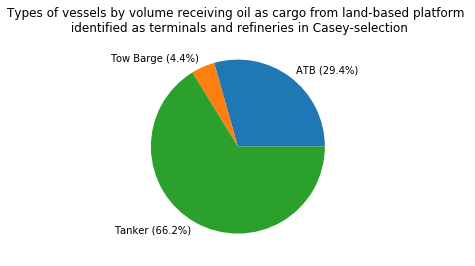

In [11]:
volume_export_byvessel = [oil_traffic['cargo']['atb']['volume_export_total'], oil_traffic['cargo']['barge']['volume_export_total'], oil_traffic['cargo']['tanker']['volume_export_total']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Tanker ({tanker_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(volume_export_byvessel, labels= labels)
plt.title('Types of vessels by volume receiving oil as cargo from land-based platform \n identified as terminals and refineries in Casey-selection')

#### By oil type within vessel type classification

In [12]:
oil_traffic['cargo']['atb']['CRUDE']=0
oil_traffic['cargo']['atb']['GASOLINE']=0
oil_traffic['cargo']['atb']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['atb']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['atb']['other']=0

oil_traffic['cargo']['barge']['CRUDE']=0
oil_traffic['cargo']['barge']['GASOLINE']=0
oil_traffic['cargo']['barge']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['barge']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['barge']['other']=0

oil_traffic['cargo']['tanker']['CRUDE']=0
oil_traffic['cargo']['tanker']['GASOLINE']=0
oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE']=0
oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL']=0
oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)']=0
oil_traffic['cargo']['tanker']['BUNKER OIL/HFO']=0
oil_traffic['cargo']['tanker']['other']=0

oil_types = ['CRUDE', 'GASOLINE', 'JET FUEL/KEROSENE','DIESEL/MARINE GAS OIL', 
             'DIESEL LOW SULPHUR (ULSD)', 'BUNKER OIL/HFO', 'other']

percent_check = 0
for oil_name in range(len(oil_types)):
    
    # ATBs
    for rows in range(len(oil_traffic['cargo']['atb']['volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['atb']['oil_type'][rows]: 
            oil_traffic['cargo']['atb'][oil_types[oil_name]] += oil_traffic['cargo']['atb']['volume_export'][rows]
    
    # Barges
    for rows in range(len(oil_traffic['cargo']['barge']['volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['barge']['oil_type'][rows]: 
            oil_traffic['cargo']['barge'][oil_types[oil_name]] += oil_traffic['cargo']['barge']['volume_export'][rows]
    
    # Tankers (non-ATB or Barge)
    for rows in range(len(oil_traffic['cargo']['tanker']['volume_export'])):  
        if oil_types[oil_name] in oil_traffic['cargo']['tanker']['oil_type'][rows]: 
            oil_traffic['cargo']['tanker'][oil_types[oil_name]] += oil_traffic['cargo']['tanker']['volume_export'][rows]
    
    # calculate percentages based on total oil cargo exports
    oil_traffic['cargo']['atb']['percent_volume_export'][oil_types[oil_name]]    = 100 * oil_traffic['cargo']['atb'][oil_types[oil_name]]/oil_traffic['cargo']['export_total']['all']
    oil_traffic['cargo']['barge']['percent_volume_export'][oil_types[oil_name]]  = 100 * oil_traffic['cargo']['barge'][oil_types[oil_name]]/oil_traffic['cargo']['export_total']['all']
    oil_traffic['cargo']['tanker']['percent_volume_export'][oil_types[oil_name]] = 100 * oil_traffic['cargo']['tanker'][oil_types[oil_name]]/oil_traffic['cargo']['export_total']['all']
    
    for name in ['atb', 'barge', 'tanker']:
        percent_check += oil_traffic['cargo'][f'{name}']['percent_volume_export'][oil_types[oil_name]]

percent_check        

89.84399461809755

#### Plot up ATB fuel types

Text(0.5,1,'Types of oil transport by volume for ATBs from WA refineries and terminals')

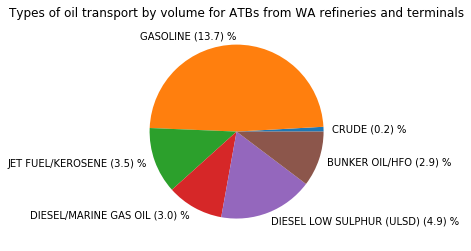

In [13]:
atb_volume_export = [oil_traffic['cargo']['atb']['CRUDE'],
                    oil_traffic['cargo']['atb']['GASOLINE'],
                    oil_traffic['cargo']['atb']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['atb']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['atb']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['atb']['BUNKER OIL/HFO']]
labels = []
for ii in range(len(oil_types)-1):
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["atb"]["percent_volume_export"][oil_types[ii]]:3.1f}) %')
    
plt.gca().axis("equal")
plt.pie(atb_volume_export, labels= labels)
plt.title('Types of oil transport by volume for ATBs from WA refineries and terminals')

#### Plot up Barge fuel types

Text(0.5,1,'Types of oil transport by volume for barges from WA refineries and terminals')

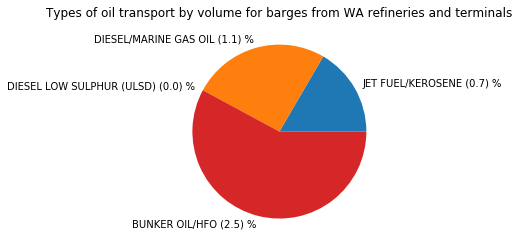

In [14]:
# barge_volume_export = [oil_traffic['cargo']['barge']['CRUDE'],
#                     oil_traffic['cargo']['barge']['GASOLINE'],
#                     oil_traffic['cargo']['barge']['JET FUEL/KEROSENE'],
#                     oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL'],
#                     oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)'],
#                     oil_traffic['cargo']['barge']['BUNKER OIL/HFO'],
#                     oil_traffic['cargo']['barge']['other']]
barge_volume_export = [oil_traffic['cargo']['barge']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['barge']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['barge']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['barge']['BUNKER OIL/HFO']]
labels = []
for ii in [2,3,4,5]:
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["barge"]["percent_volume_export"][oil_types[ii]]:3.1f}) %')

plt.gca().axis("equal")
plt.pie(barge_volume_export, labels= labels)
plt.title('Types of oil transport by volume for barges from WA refineries and terminals')

#### Plot up Tanker fuel types

Text(0.5,1,'Types of oil transport by volume for tankers from WA refineries and terminals\n with percent of net crude export')

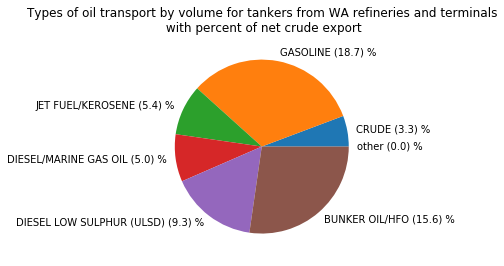

In [15]:
tanker_volume_export = [oil_traffic['cargo']['tanker']['CRUDE'],
                    oil_traffic['cargo']['tanker']['GASOLINE'],
                    oil_traffic['cargo']['tanker']['JET FUEL/KEROSENE'],
                    oil_traffic['cargo']['tanker']['DIESEL/MARINE GAS OIL'],
                    oil_traffic['cargo']['tanker']['DIESEL LOW SULPHUR (ULSD)'],
                    oil_traffic['cargo']['tanker']['BUNKER OIL/HFO'],
                    oil_traffic['cargo']['tanker']['other']]
labels = []
for ii in range(len(oil_types)):
    labels.append(f'{oil_types[ii]} ({oil_traffic["cargo"]["tanker"]["percent_volume_export"][oil_types[ii]]:3.1f}) %')

plt.gca().axis("equal")
plt.pie(tanker_volume_export, labels= labels)
plt.title('Types of oil transport by volume for tankers from WA refineries and terminals\n with percent of net crude export')

#### This is the wrong way (includes ship-to-ship transfers)

In [16]:
# # remove cargo fuel transfers to land-based entity in order to isolate export cargo
# oil_traffic['cargo'] = {}
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refinery')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refining')] # this is specifically for U.S. Oil in Tacoma
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Terminal')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Petroleum')] # This is for smaller outfits, like Ranier Petroleum or Maxum Petrolem
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Inc')] # Covich, Petrocard
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('LLC')] # Pacific Functional Fluids, LLC; Coleman Oil Company, LLC
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Ballard Oil Co.')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Reisner Distributor, Inc.')]
# cargo_data = cargo_data[~cargo_data.Receiver.str.contains('NASWI')]

# # This dataset contains Columbia River locations that need to be scrubbed out
# cargo_data = cargo_data[~cargo_data.City.str.contains('vancouver')]

# # cargo_data is no longer indexed chronologically after removing 'Refinery', 'Terminal' and 'NASWI' entries
# # need to re-set indexing in order to use row-index as data_frame index
# cargo_data.reset_index(drop=True, inplace=True)
# [nrows,ncols] = cargo_data.shape

# # introduce dictionary entries for fuel volume export
# oil_traffic['cargo']['atb_volume_export']   = 0
# oil_traffic['cargo']['barge_volume_export'] = 0
# oil_traffic['cargo']['other_export'] = 0
# oil_traffic['cargo']['ship_to_ship'] = 0
# oil_traffic['cargo']['total']        = 0

# # carrier names
# oil_traffic['cargo']['atb_carrier']={}

# # total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
# for rows in range(nrows):
#     # from land-based terminals and refineries only
#     if 'Refinery' in cargo_data.Deliverer[rows] or 'Refining' in cargo_data.Deliverer[rows] or 'Terminal' in cargo_data.Deliverer[rows]: 
#         if 'ATB' in cargo_data.Receiver[rows] :
#             oil_traffic['cargo']['atb_volume_export'] = oil_traffic['cargo']['atb_volume_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#             #if cargo_data.Receiver[rows] not in oil_traffic['cargo']['atb_carrier']:
#             #    oil_traffic['cargo']['atb_carrier'][f'{oil_traffic['cargo']['atb_carrier']}']=[f'{oil_traffic['cargo']['atb_carrier']}']
#         elif 'BARGE' in cargo_data.Receiver[rows] or 'Barge' in cargo_data.Receiver[rows] or 'PB' in cargo_data.Receiver[rows] or 'YON' in cargo_data.Receiver[rows] or 'DLB' in cargo_data.Receiver[rows]:  # and not 'ATB' in cargo_data.Receiver[rows]:  
#             oil_traffic['cargo']['barge_volume_export'] = oil_traffic['cargo']['barge_volume_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#         else:
#             oil_traffic['cargo']['other_export'] = oil_traffic['cargo']['other_export'] + cargo_data.TransferQtyInGallon[rows]
#             #display(cargo_data.Receiver[rows])
#     else:
#         oil_traffic['cargo']['ship_to_ship'] = oil_traffic['cargo']['ship_to_ship'] + cargo_data.TransferQtyInGallon[rows]
        
# oil_traffic['cargo']['total'] = oil_traffic['cargo']['atb_volume_export'] + oil_traffic['cargo']['barge_volume_export'] + oil_traffic['cargo']['other_export'] + oil_traffic['cargo']['ship_to_ship']
# oil_traffic['cargo']['total']/cargo_data.TransferQtyInGallon.sum()

### Add up volume transferred by fuel type 

In [17]:
# Add up the total volume of marine transport by product (this includes all transfers)
gas_export_data    = cargo_data[cargo_data['Product']=='GASOLINE']
gas_export_total   = gas_export_data['TransferQtyInGallon'].sum()
gas_export_percent = 100*gas_export_total/cargo_data.TransferQtyInGallon.sum()

diesel_export_data    = cargo_data[cargo_data['Product']=='DIESEL/MARINE GAS OIL']
diesel_export_total   = diesel_export_data['TransferQtyInGallon'].sum()
diesel_export_percent = 100*diesel_export_total/cargo_data.TransferQtyInGallon.sum()

bunker_export_data  = cargo_data[cargo_data['Product']=='BUNKER OIL/HFO']
bunker_export_total = bunker_export_data['TransferQtyInGallon'].sum()
bunker_export_percent = 100*bunker_export_total/cargo_data.TransferQtyInGallon.sum()

jet_export_data   = cargo_data[cargo_data['Product']=='JET FUEL/KEROSENE']
jet_export_total  = jet_export_data['TransferQtyInGallon'].sum()
jet_export_percent = 100*jet_export_total/cargo_data.TransferQtyInGallon.sum()

ulsd_export_data  = cargo_data[cargo_data['Product']=='DIESEL LOW SULPHUR (ULSD)']
ulsd_export_total = ulsd_export_data['TransferQtyInGallon'].sum()
ulsd_export_percent = 100*ulsd_export_total/cargo_data.TransferQtyInGallon.sum()


crude_export_data  = cargo_data[cargo_data['Product'].str.contains('CRUDE')]
crude_export_total = crude_export_data['TransferQtyInGallon'].sum()
crude_export_percent = 100*crude_export_total/cargo_data.TransferQtyInGallon.sum()

Other_fuel_total = cargo_data['TransferQtyInGallon'].sum() - crude_export_total - ulsd_export_total - jet_export_total - bunker_export_total - diesel_export_total - gas_export_total 
other_fuel_percent = 100*Other_fuel_total/cargo_data.TransferQtyInGallon.sum()

total_percent = other_fuel_percent+crude_export_percent+ulsd_export_percent+jet_export_percent+bunker_export_percent+diesel_export_percent+gas_export_percent
total_percent

100.0

### Plot up results

Text(0.5,1,'Marine Oil Export from WA Refineries and Terminals')

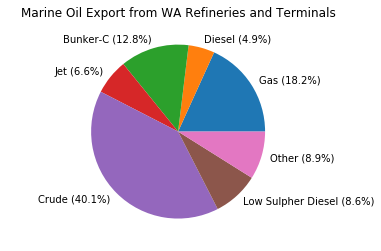

In [18]:
oil_export_values = [gas_export_total, diesel_export_total , bunker_export_total, jet_export_total, crude_export_total, ulsd_export_total, Other_fuel_total]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'Gas ({gas_export_percent:3.1f}%)', f'Diesel ({diesel_export_percent:3.1f}%)', f'Bunker-C ({bunker_export_percent:3.1f}%)', f'Jet ({jet_export_percent:3.1f}%)', f'Crude ({crude_export_percent:3.1f}%)', f'Low Sulpher Diesel ({ulsd_export_percent:3.1f}%)', f'Other ({other_fuel_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(oil_export_values, labels= labels)
plt.title('Marine Oil Export from WA Refineries and Terminals')

In [19]:
cargo_data

,StartDateTime,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription
1,2018-01-02 07:00:00,TLP Management Services LLC (TMS),GLOBAL PILOT,DIESEL/MARINE GAS OIL,546000,Cargo,Facility,TANK BARGE
2,2018-01-01 04:30:00,POLAR RESOLUTION,Phillips 66 Ferndale Refinery,CRUDE OIL,12390000,Cargo,TANK SHIP,Facility
3,2018-01-02 07:00:00,Phillips 66 Ferndale Refinery,NATHAN SCHMIDT,BUNKER OIL/HFO,1176000,Cargo,Facility,TANK BARGE
4,2018-01-02 08:00:00,SKS SEGURA,BP Cherry Point Refinery,CRUDE OIL,8820000,Cargo,TANK SHIP,Facility
5,2018-01-01 07:00:00,ITB ISLAND TRADER,SeaPort Sound Terminal,GASOLINE,966000,Cargo,TANK BARGE,Facility
6,2018-01-02 08:00:00,ITB ISLAND TRADER,Shell Oil LP Seattle Distribution Terminal,GASOLINE,1680000,Cargo,TANK BARGE,Facility
7,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,BUNKER OIL/HFO,3150000,Cargo,Facility,TANK BARGE
8,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,DIESEL/MARINE GAS OIL,3360000,Cargo,Facility,TANK BARGE
9,2018-01-03 02:00:00,Shell Puget Sound Refinery,CARTAGENA,GASOLINE,7560000,Cargo,Facility,TANK SHIP
20,2018-01-01 00:01:00,Phillips 66 Ferndale Refinery,PROFESSOR KAREN ANN BROWN,DIESEL/MARINE GAS OIL,399000,Cargo,Facility,TANK BARGE
